## Import packages

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import xesmf as xe
import numpy as np
import geopandas as gpd
import shapely.geometry as geom
import matplotlib.gridspec as gridspec

## Load data 

In [3]:
datapath = f'/g/data/ng72/as9583/cylc-run/u-dr216/netcdf'
# variable = 'air_temperature_1p5m' #if using this, need to delete the factor at bottom - thats for rainfall
variable = 'stratiform_rainfall_flux'

experiment1 = 'drysoil_d0198_RAL3P2_albedo_bare_' 
allvar = xr.open_dataset(f'{datapath}/{variable}/{experiment1}{variable}.nc')[variable]

experiment2 = 'control_d0198_RAL3P2_' 
control = xr.open_dataset(f'{datapath}/{variable}/{experiment2}{variable}.nc')[variable]

experiment3 = 'control_d0198_RAL3P2_albedo_bare_'
albedo_bare = xr.open_dataset(f'{datapath}/{variable}/{experiment3}{variable}.nc')[variable]

experiment4 = 'control_d0198_RAL3P2_albedo_'
albedo = xr.open_dataset(f'{datapath}/{variable}/{experiment4}{variable}.nc')[variable]

experiment5 = 'control_d0198_RAL3P2_bare_'
bare = xr.open_dataset(f'{datapath}/{variable}/{experiment5}{variable}.nc')[variable]

experiment6 = 'drysoil_d0198_RAL3P2_albedo_'
SM_albedo = xr.open_dataset(f'{datapath}/{variable}/{experiment6}{variable}.nc')[variable]

experiment7 = 'drysoil_d0198_RAL3P2_bare_'
SM_bare = xr.open_dataset(f'{datapath}/{variable}/{experiment7}{variable}.nc')[variable]

experiment8 = 'drysoil_d0198_RAL3P2_'
SM = xr.open_dataset(f'{datapath}/{variable}/{experiment8}{variable}.nc')[variable]


In [4]:
fires = gpd.read_file('/g/data/ng72/as9583/merged_fires.gpkg')
variable2 = 'surface_altitude'
sa1 = xr.open_dataset(f'{datapath}/{variable2}/{experiment1}{variable2}.nc')[variable2].isel(time=0)

## Land only, sum to daily totals

In [5]:
#clip to land only
variable3 = 'land_sea_mask'
landmask = xr.open_dataset(f'{datapath}/{variable3}/{experiment1}{variable3}.nc')["land_binary_mask"].isel(time=0)
allvar = allvar.where(landmask == 1)
control = control.where(landmask == 1)
albedo_bare = albedo_bare.where(landmask == 1)
albedo = albedo.where(landmask == 1)
bare = bare.where(landmask == 1)
SM_albedo = SM_albedo.where(landmask == 1)
SM_bare = SM_bare.where(landmask == 1)
SM = SM.where(landmask == 1)

In [6]:
allvar_total = (allvar * 3600).sum(dim="time", skipna=True)
control_total = (control * 3600).sum(dim="time", skipna=True)
albedo_bare_total = (albedo_bare * 3600).sum(dim="time", skipna=True)
albedo_total = (albedo * 3600).sum(dim="time", skipna=True)
bare_total = (bare * 3600).sum(dim="time", skipna=True)
SM_albedo_total = (SM_albedo * 3600).sum(dim="time", skipna=True)
SM_bare_total = (SM_bare  * 3600).sum(dim="time", skipna=True)
SM_total = (SM * 3600).sum(dim="time", skipna=True)

## difference plots, one suite

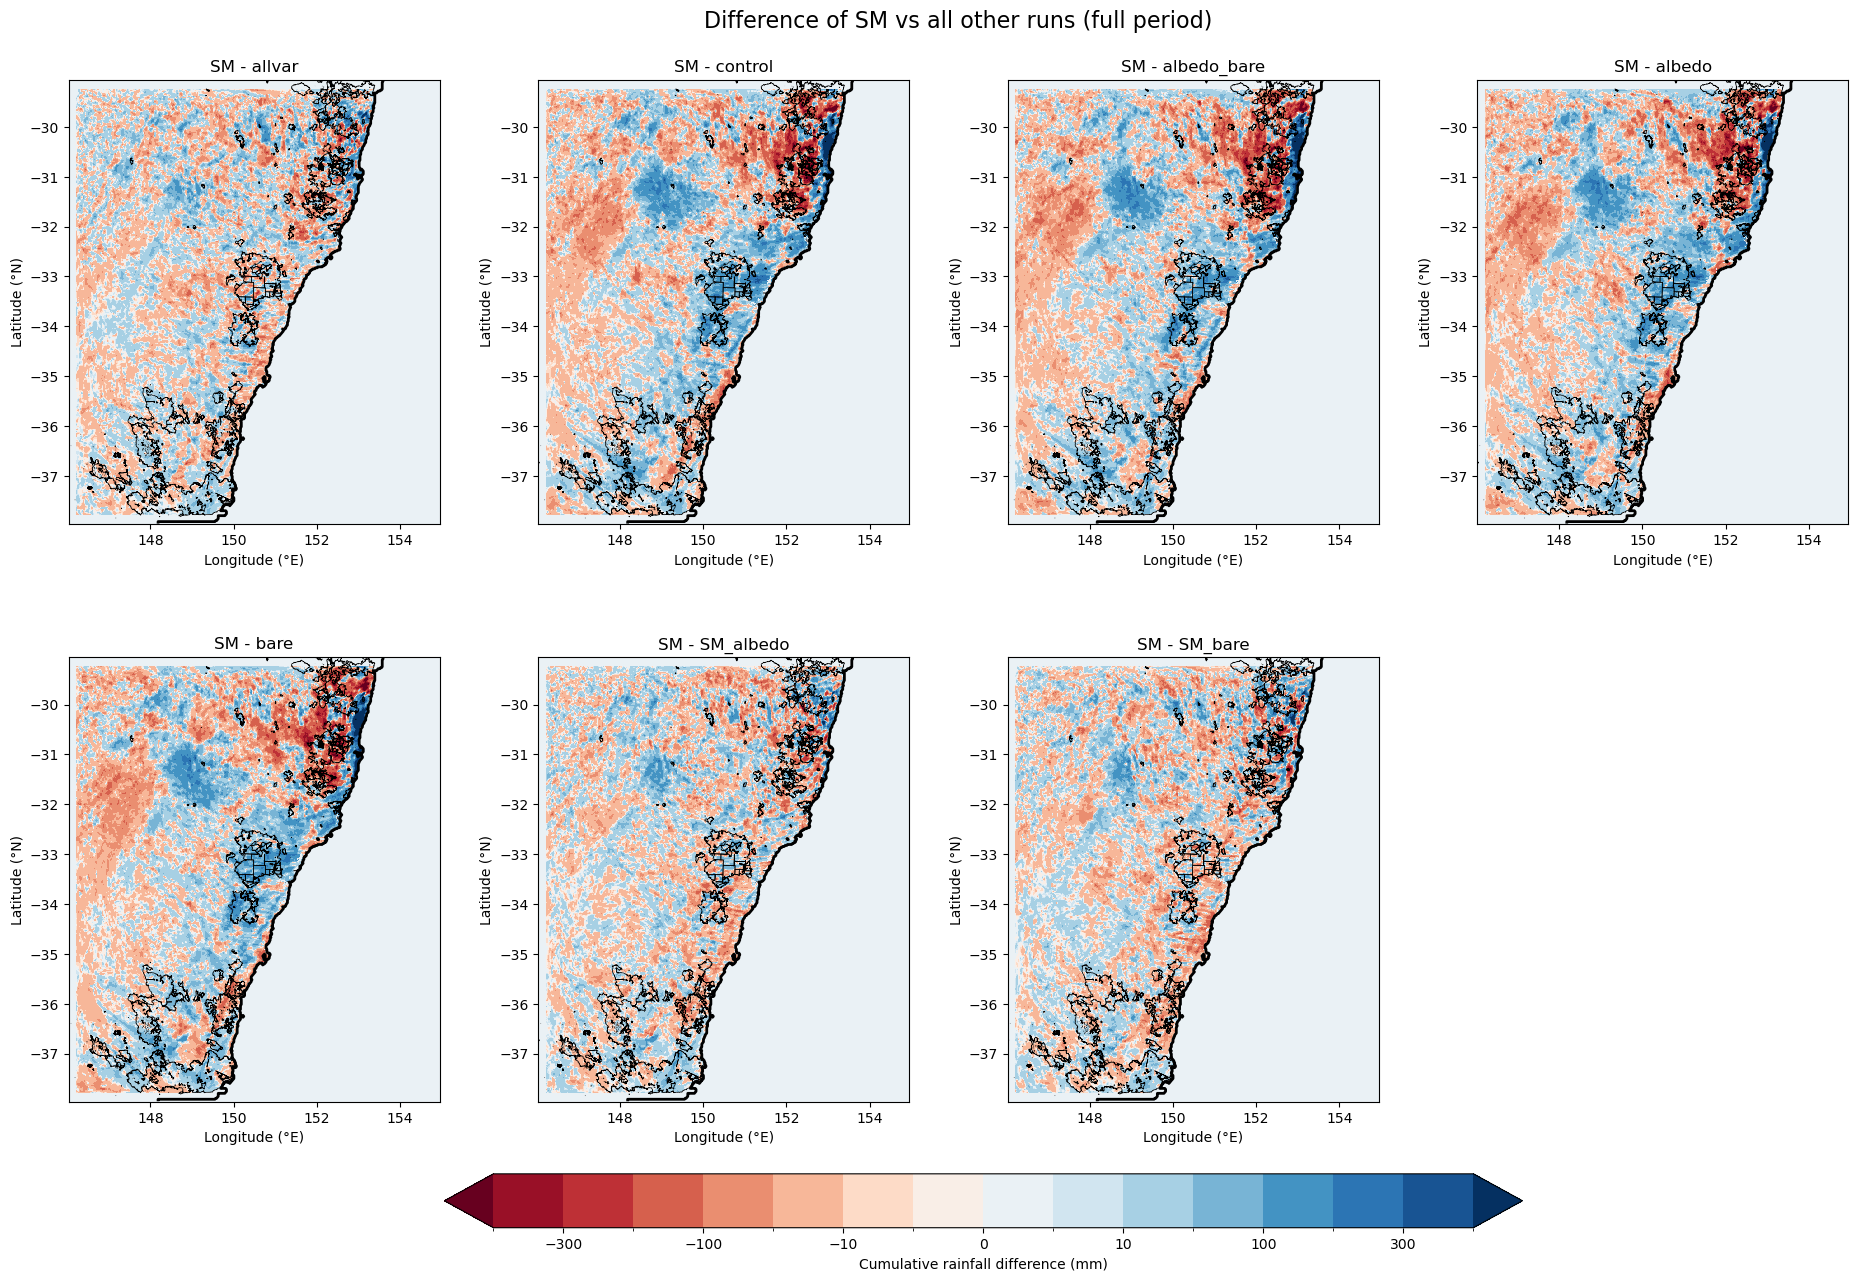

In [15]:
totals = {
    "allvar": allvar_total,
    "control": control_total,
    "albedo_bare": albedo_bare_total,
    "albedo": albedo_total,
    "bare": bare_total,
    "SM_albedo": SM_albedo_total,
    "SM_bare": SM_bare_total,
    "SM": SM_total,
}

names = list(totals.keys())
ref_index = 7 # index of reference number, starting at 0 for all var, ends at 7 
ref_name = names[ref_index]

ncols = 4
nrows = 2

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 14))
axes = axes.flatten()

plot_idx = 0
cbar_ax = None 

for i, name in enumerate(names):
    if i == ref_index:
        continue  #skip reference 

    diff = totals[ref_name] - totals[name]
    ax = axes[plot_idx]

    mesh = diff.plot(
        ax=ax,
        cmap="RdBu",
        center=0,
        levels=[-400, -300, -200, -100, -50, -10, -5, 0, 5, 10, 50, 100, 200, 300, 400],
        extend="both",
        add_colorbar=False
    )

    if plot_idx == 0:
        cbar_ax = mesh  # first plot defines colorbar

    sa1.plot.contour(ax=ax, levels=[0], colors="black", linewidths=2, add_colorbar=False)
    gpd.GeoSeries(fires.boundary).plot(ax=ax, edgecolor="black", linewidth=0.5)

    ax.set_title(f"{ref_name} - {name}")
    ax.set_xlabel("Longitude (°E)", fontsize=10)
    ax.set_ylabel("Latitude (°N)", fontsize=10)

    plot_idx += 1

# remove unused axes (the 8th subplot)
for j in range(plot_idx, len(axes)):
    fig.delaxes(axes[j])

# # shared colorbar along the bottom
# fig.colorbar(cbar_ax, ax=axes[:plot_idx], orientation="horizontal",
#              fraction=0.05, pad=0.05, label="Cumulative rainfall difference (mm)")
fig.colorbar(
    cbar_ax, ax=axes[:plot_idx],
    orientation='horizontal',
    fraction=0.05,  # thickness of colorbar
    pad=0.02,       # space between axes and colorbar
    label="Cumulative rainfall difference (mm)"
)

# adjust subplot spacing
# fig.subplots_adjust(left=0.05, right=0.95, top=0.93, bottom=0.12, hspace=0.3, wspace=0.2)
fig.subplots_adjust(left=0.05, right=0.95, top=0.93, bottom=0.20, hspace=0.3, wspace=0.2)

fig.suptitle(f"Difference of {ref_name} vs all other runs (full period)", fontsize=16)
plt.show()


## difference plots, all suites, no repeats

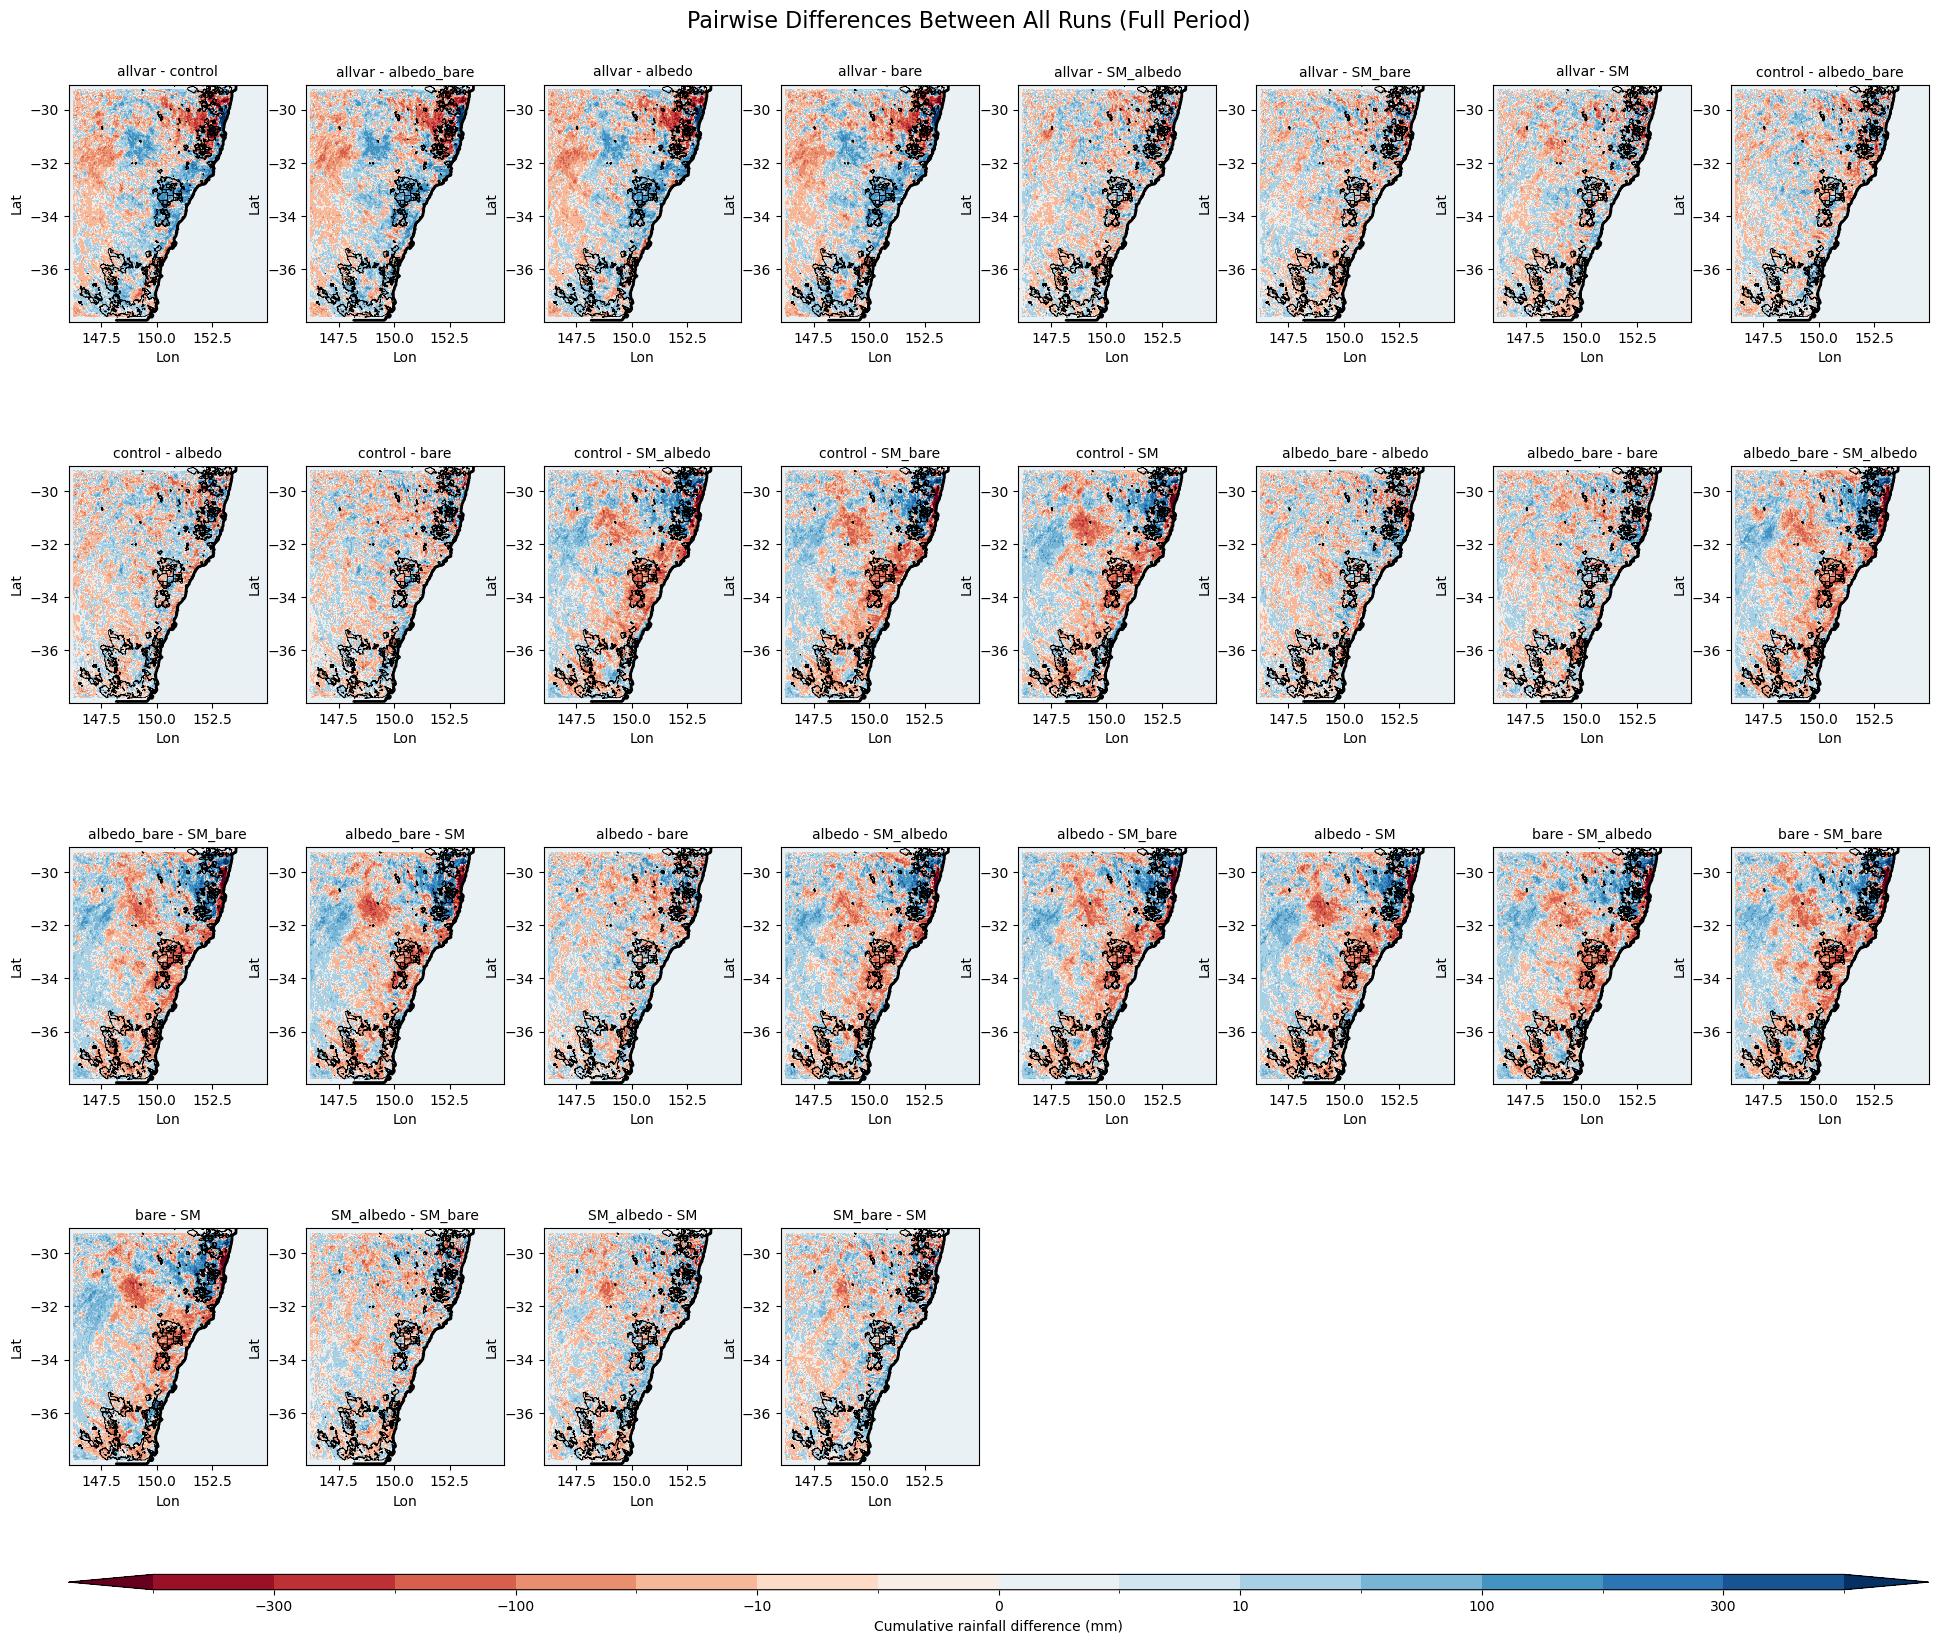

In [23]:
totals = {
    "allvar": allvar_total,
    "control": control_total,
    "albedo_bare": albedo_bare_total,
    "albedo": albedo_total,
    "bare": bare_total,
    "SM_albedo": SM_albedo_total,
    "SM_bare": SM_bare_total,
    "SM": SM_total,
}

names = list(totals.keys())
n_experiments = len(names)

#combinations 
pairs = [(i, j) for i in range(n_experiments) for j in range(i+1, n_experiments)]
n_plots = len(pairs)

ncols = 8
nrows = int(np.ceil(len(pairs) / ncols))

# Use GridSpec to reserve bottom row for colorbar
fig = plt.figure(figsize=(24, 5*nrows))
gs = gridspec.GridSpec(nrows + 1, ncols, height_ratios=[1]*nrows + [0.05], hspace=0.3, wspace=0.2)

axes = []
for i in range(nrows):
    for j in range(ncols):
        axes.append(fig.add_subplot(gs[i, j]))

plot_idx = 0
cbar_ax = None

for idx, (i, j) in enumerate(pairs):
    if plot_idx >= len(axes):
        break  
    ax = axes[plot_idx]
    
    ref_name = names[i]
    target_name = names[j]
    
    diff = totals[ref_name] - totals[target_name]
    
    mesh = diff.plot(
        ax=ax,
        cmap="RdBu",
        center=0,
        levels=[-400, -300, -200, -100, -50, -10, -5, 0, 5, 10, 50, 100, 200, 300, 400],
        extend="both",
        add_colorbar=False
    )
    
    if cbar_ax is None:
        cbar_ax = mesh 
    
    sa1.plot.contour(ax=ax, levels=[0], colors="black", linewidths=2, add_colorbar=False)
    gpd.GeoSeries(fires.boundary).plot(ax=ax, edgecolor="black", linewidth=0.5)
    
    ax.set_title(f"{ref_name} - {target_name}", fontsize=10)
    ax.set_xlabel("Lon")
    ax.set_ylabel("Lat")
    
    plot_idx += 1

for j in range(plot_idx, len(axes)):
    fig.delaxes(axes[j])

fig.colorbar(cbar_ax, cax=fig.add_subplot(gs[nrows, :]), orientation='horizontal',
             label="Cumulative rainfall difference (mm)")

fig.suptitle("Pairwise Differences Between All Runs (Full Period)", fontsize=16, y=0.9)
plt.show()


## all suites, inclusive of repeats ie a - b AND b - a

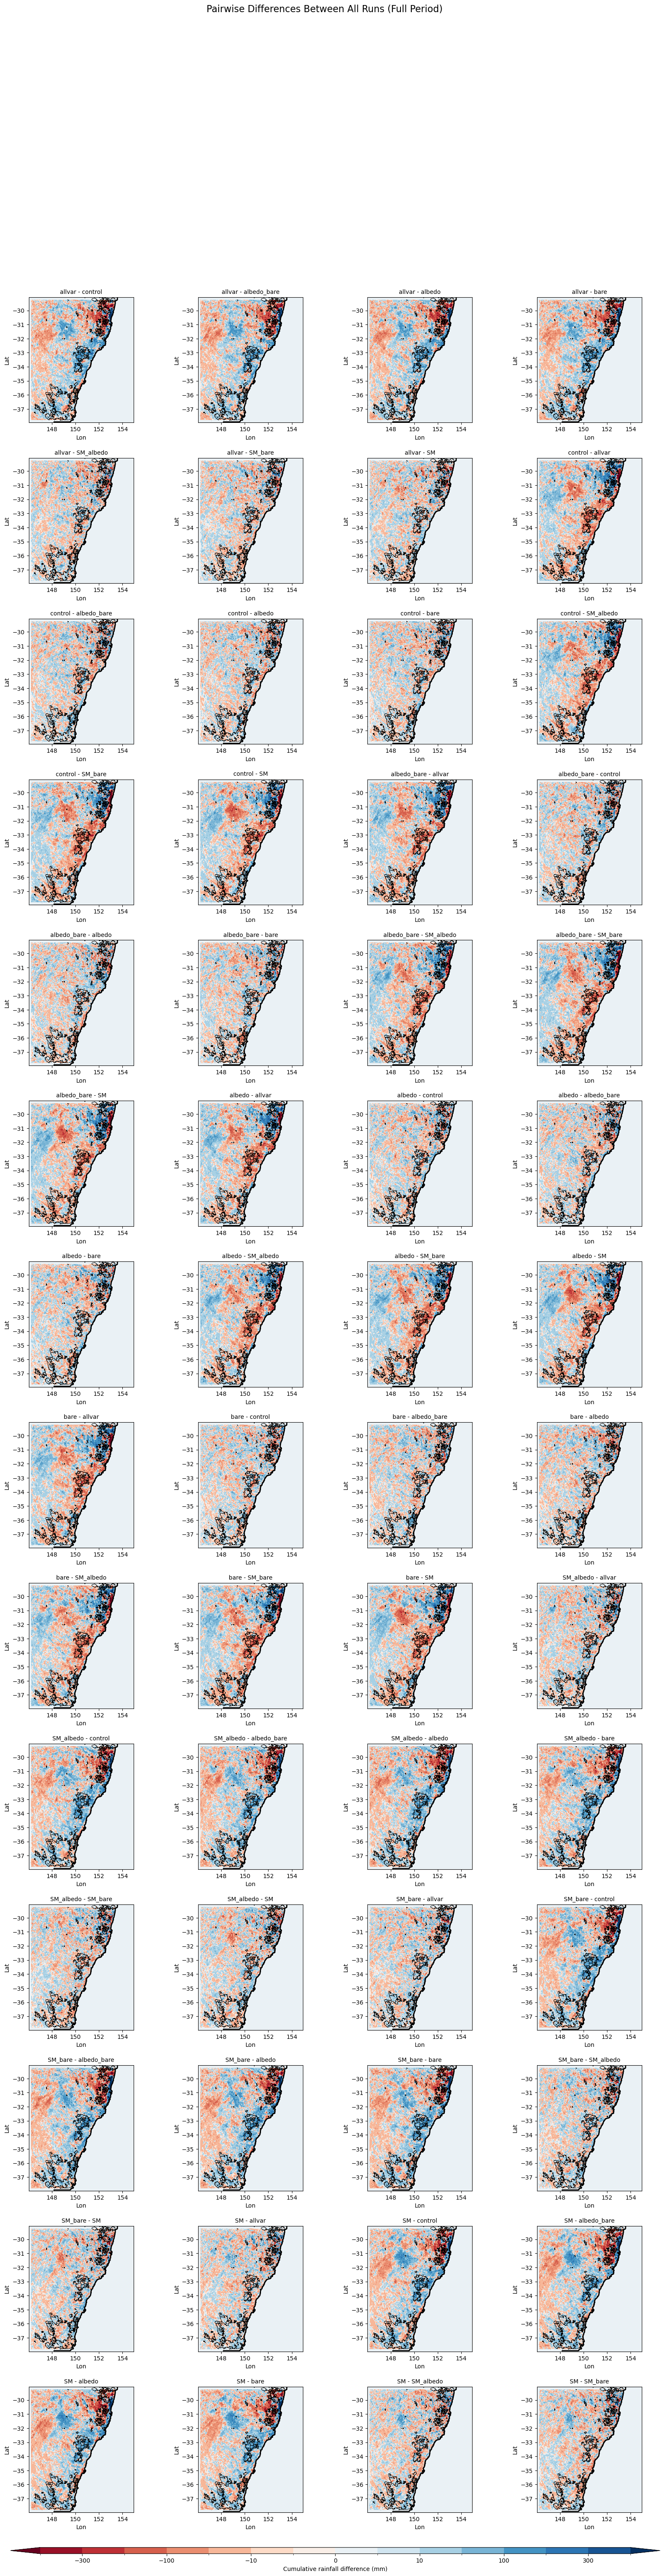

In [17]:
totals = {
    "allvar": allvar_total,
    "control": control_total,
    "albedo_bare": albedo_bare_total,
    "albedo": albedo_total,
    "bare": bare_total,
    "SM_albedo": SM_albedo_total,
    "SM_bare": SM_bare_total,
    "SM": SM_total,
}

names = list(totals.keys())
n_experiments = len(names)

#combinations 
pairs = [(i, j) for i in range(n_experiments) for j in range(n_experiments) if i != j]
n_plots = len(pairs)

ncols = 4
nrows = int(np.ceil(len(pairs) / ncols))

# Use GridSpec to reserve bottom row for colorbar
fig = plt.figure(figsize=(20, 5*nrows))
gs = gridspec.GridSpec(nrows + 1, ncols, height_ratios=[1]*nrows + [0.05], hspace=0.3, wspace=0.2)

axes = []
for i in range(nrows):
    for j in range(ncols):
        axes.append(fig.add_subplot(gs[i, j]))

plot_idx = 0
cbar_ax = None

for idx, (i, j) in enumerate(pairs):
    if plot_idx >= len(axes):
        break  
    ax = axes[plot_idx]
    
    ref_name = names[i]
    target_name = names[j]
    
    diff = totals[ref_name] - totals[target_name]
    
    mesh = diff.plot(
        ax=ax,
        cmap="RdBu",
        center=0,
        levels=[-400, -300, -200, -100, -50, -10, -5, 0, 5, 10, 50, 100, 200, 300, 400],
        extend="both",
        add_colorbar=False
    )
    
    if cbar_ax is None:
        cbar_ax = mesh 
    
    sa1.plot.contour(ax=ax, levels=[0], colors="black", linewidths=2, add_colorbar=False)
    gpd.GeoSeries(fires.boundary).plot(ax=ax, edgecolor="black", linewidth=0.5)
    
    ax.set_title(f"{ref_name} - {target_name}", fontsize=10)
    ax.set_xlabel("Lon")
    ax.set_ylabel("Lat")
    
    plot_idx += 1

for j in range(plot_idx, len(axes)):
    fig.delaxes(axes[j])

fig.colorbar(cbar_ax, cax=fig.add_subplot(gs[nrows, :]), orientation='horizontal',
             label="Cumulative rainfall difference (mm)")

fig.suptitle("Pairwise Differences Between All Runs (Full Period)", fontsize=16)
plt.show()
